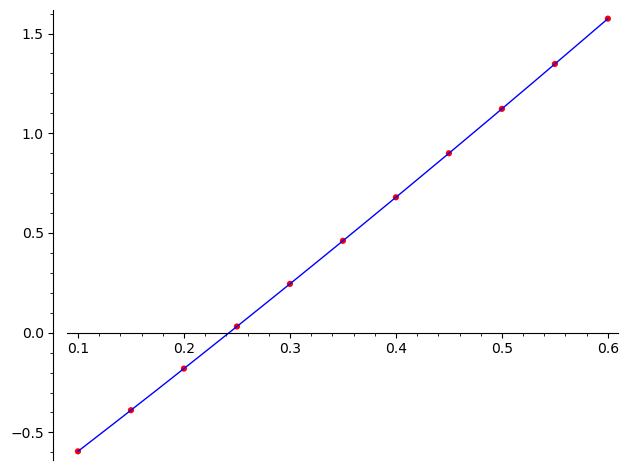

In [102]:
class Grid:
    def __init__(self, left_border, right_border, steps_count, function):
        step = (right_border - left_border) / steps_count
        self.x = [left_border + i * step for i in range(steps_count + 1)]
        self.y = [function(x=x) for x in self.x]
        self.h = step
        self.mu = SR(1) / SR(2)
        self.lambda_ = self.mu
        self.gamma = SR(1)


target_x = 0.37
left_border = 0.1
right_border = 0.6
steps_count = 10

x = var('x')
y = 4 * x - cos(x)

grid = Grid(left_border, right_border, steps_count, y)

p = y.plot(xmin=left_border, xmax=right_border)
p += point(zip(grid.x, grid.y), color='red', pointsize=20)
p.show()

In [103]:


def get_3diagonal_matrix(grid: Grid) -> Matrix:
    rows = []
    rows.append([1 + grid.gamma, grid.gamma, *[0 for _ in range(len(grid.x) - 2)]])
    for i in range(1, len(grid.x) - 1):
        rows.append([*[0 for _ in range(i - 1)], grid.mu, 2, grid.lambda_, *[0 for _ in range(i + 2, len(grid.x))]])
    rows.append([*[0 for _ in range(len(grid.x) - 2)], grid.gamma, 1 + grid.gamma])
    return Matrix(rows)


def get_right_side(grid: Grid) -> vector:
    values = []
    values.append(grid.lambda_ * (3 + 2 * grid.gamma) * (grid.y[2] - grid.y[1]) / grid.h + grid.mu * (
            grid.y[1] - grid.y[0]) / grid.h)
    for i in range(1, len(grid.x) - 1):
        values.append(
            3 * (grid.lambda_ * (grid.y[i + 1] - grid.y[i]) / grid.h + grid.mu * (grid.y[i] - grid.y[i - 1]) / grid.h))

    values.append(
        grid.mu * (3 + 2 * grid.gamma) * (grid.y[len(grid.y) - 2] - grid.y[len(grid.y) - 3]) / grid.h + grid.lambda_ * (
                    grid.y[len(grid.y) - 1] - grid.y[len(grid.y) - 2]) / grid.h)
    return vector(values)

In [104]:

coefficents_matrix = get_3diagonal_matrix(grid)

In [105]:
print(coefficents_matrix)

[  2   1   0   0   0   0   0   0   0   0   0]
[1/2   2 1/2   0   0   0   0   0   0   0   0]
[  0 1/2   2 1/2   0   0   0   0   0   0   0]
[  0   0 1/2   2 1/2   0   0   0   0   0   0]
[  0   0   0 1/2   2 1/2   0   0   0   0   0]
[  0   0   0   0 1/2   2 1/2   0   0   0   0]
[  0   0   0   0   0 1/2   2 1/2   0   0   0]
[  0   0   0   0   0   0 1/2   2 1/2   0   0]
[  0   0   0   0   0   0   0 1/2   2 1/2   0]
[  0   0   0   0   0   0   0   0 1/2   2 1/2]
[  0   0   0   0   0   0   0   0   0   1   2]


In [106]:
right_side = get_right_side(grid)

In [107]:
print(right_side)

(12.4975558781599, 12.4481276231035, 12.5957596867619, 12.7419026614691, 12.8861912658980, 13.0282648536816, 13.1677683148411, 13.3043529633754, 13.4376774087951, 13.5674084094208, 13.5247910630416)


In [108]:
u_s = vector([var(f'u{i}') for i in range(len(grid.x))])

In [109]:
print(u_s)

(u0, u1, u2, u3, u4, u5, u6, u7, u8, u9, u10)


In [110]:
equations = []
for i in range(len(grid.x)):
    if i == 0:
        equations.append(u_s[i] * coefficents_matrix[i][i] + u_s[i + 1] * coefficents_matrix[i][i + 1] == right_side[i])
    elif i == len(grid.x) - 1:
        equations.append(u_s[i] * coefficents_matrix[i][i] + u_s[i - 1] * coefficents_matrix[i][i - 1] == right_side[i])
    else:
        equations.append(u_s[i - 1] * coefficents_matrix[i][i - 1] + u_s[i] * coefficents_matrix[i][i] + u_s[i + 1] *
                         coefficents_matrix[i][i + 1] == right_side[i])

In [111]:
print(equations)

[2*u0 + u1 == 12.4975558781599, 1/2*u0 + 2*u1 + 1/2*u2 == 12.4481276231035, 1/2*u1 + 2*u2 + 1/2*u3 == 12.5957596867619, 1/2*u2 + 2*u3 + 1/2*u4 == 12.7419026614691, 1/2*u3 + 2*u4 + 1/2*u5 == 12.8861912658980, 1/2*u4 + 2*u5 + 1/2*u6 == 13.0282648536816, 1/2*u5 + 2*u6 + 1/2*u7 == 13.1677683148411, 1/2*u6 + 2*u7 + 1/2*u8 == 13.3043529633754, 1/2*u7 + 2*u8 + 1/2*u9 == 13.4376774087951, 1/2*u10 + 1/2*u8 + 2*u9 == 13.5674084094208, 2*u10 + u9 == 13.5247910630416]


In [112]:
tma_coefficents = [[0, 0] for i in range(len(grid.x))]
tma_coefficents[1][0] = -coefficents_matrix[0][1] / coefficents_matrix[0][0]
tma_coefficents[1][1] = right_side[0] / coefficents_matrix[0][0]
for i in range(2, len(grid.x)):
    tma_coefficents[i][0] = -coefficents_matrix[i - 1][i] / (
            coefficents_matrix[i - 1][i - 2] * tma_coefficents[i - 1][0] + coefficents_matrix[i - 1][i - 1])
    tma_coefficents[i][1] = (right_side[i - 1] - coefficents_matrix[i - 1][i - 2] * tma_coefficents[i - 1][1]) / (
            coefficents_matrix[i - 1][i - 2] * tma_coefficents[i - 1][0] + coefficents_matrix[i - 1][i - 1])
tma_coefficents = Matrix(tma_coefficents)
print("Коэффиценты прогонки")
print(tma_coefficents)
solutions = [0 for i in range(len(grid.x))]
for i in range(len(grid.x) - 1, -1, -1):
    after_substitution = None
    if i == len(grid.x) - 1:
        after_substitution = equations[i].substitute({
            u_s[i - 1]: tma_coefficents[i][0] * u_s[i] + tma_coefficents[i][1]
        })
    elif i == 0:
        after_substitution = equations[i].substitute({
            u_s[i + 1]: solutions[i + 1]
        })
    else:
        after_substitution = equations[i].substitute({
            u_s[i - 1]: tma_coefficents[i][0] * u_s[i] + tma_coefficents[i][1],
            u_s[i + 1]: solutions[i + 1]
        })
    print(f"Уравнение {i + 1} после подстновки: {after_substitution}")
    solution = after_substitution.solve(u_s[i], solution_dict=True)
    print(f"Решение: {u_s[i]} = {solution[0][u_s[i]]}")
    print()
    solutions[i] = solution[0][u_s[i]]

print(list(map(RR, solutions)))

Коэффиценты прогонки
[               0                0]
[            -1/2 6.24877793907993]
[            -2/7 5.32785065917918]
[           -7/26 5.34791080770818]
[          -26/97 5.39725007624721]
[         -97/362 5.45963493974649]
[       -362/1351 5.51893109243321]
[      -1351/5042 5.57779335200780]
[     -5042/18817 5.63521609193038]
[    -18817/70226 5.69127802239544]
[   -70226/262087 5.74577890364357]
Уравнение 11 после подстновки: 453948/262087*u10 + 5.74577890364357 == 13.5247910630416
Решение: u10 = 3588535827485/799012297523

Уравнение 10 после подстновки: 262087/140452*u9 + 5.09124639334299 == 13.5674084094208
Решение: u9 = 1194652302701/263002469891

Уравнение 9 после подстновки: 35113/18817*u8 + 5.08878881319547 == 13.4376774087951
Решение: u8 = 668970148107/149518738408

Уравнение 8 после подстновки: 18817/10084*u7 + 5.02597463435834 == 13.3043529633754
Решение: u7 = 706183999827/159180605068

Уравнение 7 после подстновки: 2521/1351*u6 + 4.97765035436370 == 13.16776

In [113]:
etalonsolution = coefficents_matrix.solve_right(right_side)
print(list(map(RR, etalonsolution)))

[4.18554131424528, 4.12647324966931, 4.20482093328453, 4.24576239071640, 4.29593482678800, 4.34288083392754, 4.38907154486511, 4.43636961629419, 4.47415591670888, 4.54236153446056, 4.49121476429054]


In [114]:
for i in range(len(grid.x)):
    if abs(solutions[i] - etalonsolution[i]) < 1e-10:
        print(f"\033[0;32mПогрешность для {u_s[i]}: {RR(abs(solutions[i] - etalonsolution[i]))}\033[0m")
    else:
        print(f"\033[0;31mПогрешность для {u_s[i]}: {RR(abs(solutions[i] - etalonsolution[i]))}\033[0m")

Погрешность для u0: 8.88178419700125e-16
Погрешность для u1: 6.21724893790088e-15
Погрешность для u2: 1.77635683940025e-15
Погрешность для u3: 1.77635683940025e-15
Погрешность для u4: 4.44089209850063e-15
Погрешность для u5: 8.88178419700125e-16
Погрешность для u6: 0.000000000000000
Погрешность для u7: 8.88178419700125e-16
Погрешность для u8: 8.88178419700125e-16
Погрешность для u9: 3.55271367880050e-15
Погрешность для u10: 8.88178419700125e-16


In [115]:
a = []
b = []
for i in range(len(grid.x) - 1):
    a.append(6 / grid.h * ((grid.y[i + 1] - grid.y[i]) / grid.h - (2 * solutions[i] + solutions[i + 1]) / 3))
    b.append(12 / grid.h ** 2 * ((solutions[i] + solutions[i + 1]) / 2 - (grid.y[i + 1] - grid.y[i]) / grid.h))

piecewice_function_middleware = []
for i in range(len(grid.x) - 1):
    piecewice_function_middleware.append(
        ((grid.x[i], grid.x[i + 1]), grid.y[i] + solutions[i] * (x - grid.x[i]) + a[i] * ((x - grid.x[i]) ** 2) / 2 + a[i] * ((x - grid.x[i]) ** 3) / 6))
final_function = piecewise(piecewice_function_middleware)

In [116]:
# (final_function.plot(xmin=0.242, xmax=0.243)+y.plot(xmin=0.242, xmax=0.243, color='magenta')).show()
# (final_function.plot(xmin=left_border, xmax=right_border)+y.plot(xmin=left_border, xmax=right_border, color='magenta')).show()
# print(final_function)
print(diff(final_function.expression_at(target_x), x, 1)(x=target_x))
# print(diff(final_function, x, 1)(x=target_x))
print(diff(y, x, 1)(x=target_x))
print(f"Погрешность: {abs(diff(final_function.expression_at(target_x), x, 1)(x=target_x)-diff(y, x, 1)(x=target_x))}")

4.36216772763070
4.36161543196496
Погрешность: 0.000552295665738001


4.36216772763070


4.36161543196496
